In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpb

In [2]:
df = pd.read_csv("marketing_campaign.csv", delimiter='\t')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder

class remove_unwanted_columns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.drop("ID", axis=1)
        X = X.drop("Dt_Customer", axis=1)
        return X

class date_time(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X["Dt_Customer"] = pd.to_datetime(X["Dt_Customer"], dayfirst=True)
        return X

class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        ohe = OneHotEncoder()
        for col in X.columns:
            if X[col].dtype == 'object':
                unique_names = X[col].unique()
                column_names = [str(value) for value in unique_names]

                matrix = ohe.fit_transform(X[[col]]).toarray()
                for i in range(len(matrix.T)):
                    X[str(col) + '_' + column_names[i]] = matrix.T[i]
                
                X = X.drop([col], axis=1)
        return X

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([
    ("Format_Date", date_time()),
    ("FeatureEncoder", FeatureEncoder())
])

df_standardized = df.copy()
df = pipe.fit_transform(df)
df.head()

,ID,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,Education_Basic,Education_2n Cycle,Marital_Status_Single,Marital_Status_Together,Marital_Status_Married,Marital_Status_Divorced,Marital_Status_Widow,Marital_Status_Alone,Marital_Status_Absurd,Marital_Status_YOLO
0,5524,1957,58138.0,0,0,2012-09-04,58,635,88,546,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2174,1954,46344.0,1,1,2014-03-08,38,11,1,6,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,4141,1965,71613.0,0,0,2013-08-21,26,426,49,127,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,6182,1984,26646.0,1,0,2014-02-10,26,11,4,20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5324,1981,58293.0,1,0,2014-01-19,94,173,43,118,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [5]:
# Testing findings
df = df.drop('Z_CostContact', axis = 1)
df = df.drop('Z_Revenue', axis=1)
df = df.drop('ID', axis=1)

<Axes: >

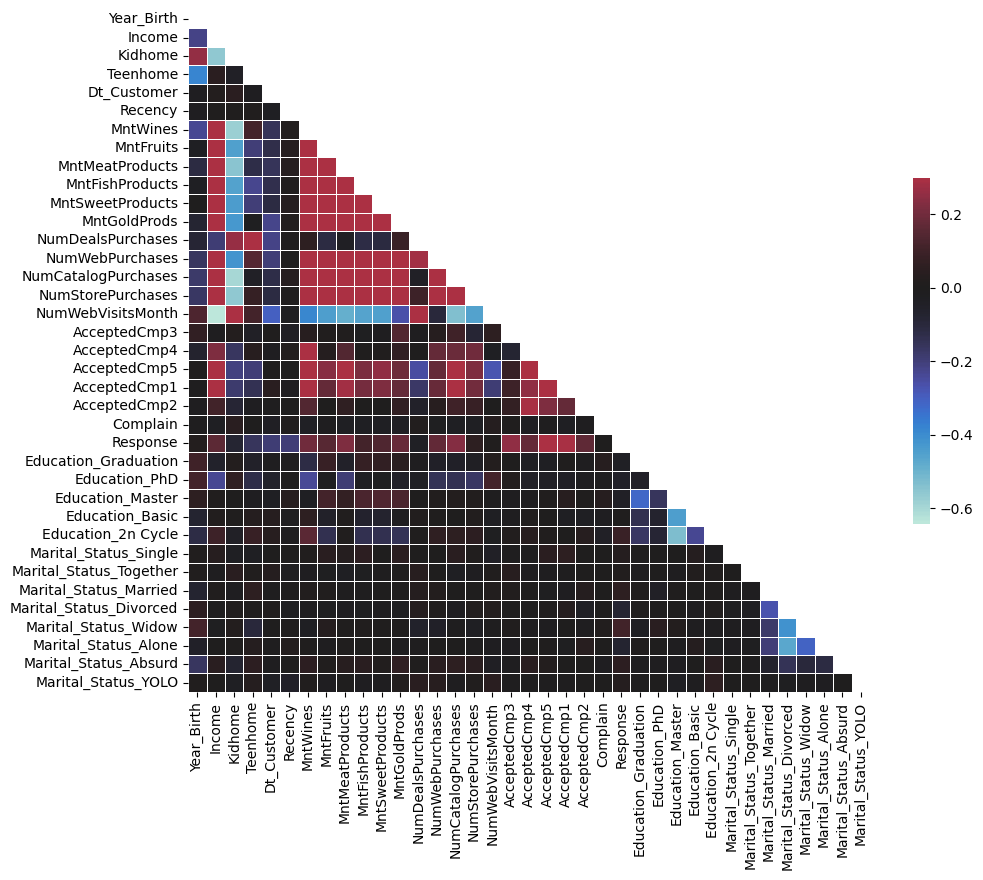

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr(method='spearman')
mask = np.triu(np.ones_like(corr))

fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr,
            mask=mask,
            vmax=.3,
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5}
            )

## Classification

In [7]:
pipe_std = Pipeline([
    ("remove_columns", remove_unwanted_columns()),
    ("FeatureEncoder", FeatureEncoder())
])

df_standardized = pipe_std.fit_transform(df_standardized)
df_standardized.head()

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Education_Basic,Education_2n Cycle,Marital_Status_Single,Marital_Status_Together,Marital_Status_Married,Marital_Status_Divorced,Marital_Status_Widow,Marital_Status_Alone,Marital_Status_Absurd,Marital_Status_YOLO
0,1957,58138.0,0,0,58,635,88,546,172,88,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1954,46344.0,1,1,38,11,1,6,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1965,71613.0,0,0,26,426,49,127,111,21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1984,26646.0,1,0,26,11,4,20,10,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1981,58293.0,1,0,94,173,43,118,46,27,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
